In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.family': 'serif'})

import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import Button, Slider
from ipywidgets import interact, IntSlider

%matplotlib ipympl
from ipywidgets import interact
from mpl_interactions import ipyplot as iplt

import math
from scipy.stats import dirichlet

from collections import OrderedDict

from trails.mtmc.ml.direct.optimized import log_ml
from trails.mtmc.common import calc_mixed_hypothesis
import trails.transition_probabilities as tp
import trails.randomwalk.randomwalk as rw
import trails.randomwalk.next_state as next_state
import trails.randomwalk.keep_walking as keep_walking
import trails.randomwalk.first_state as first_state
import trails.group_assignment as group_assignment
import trails.mtmc.common as common
import trails.utils as utils
import trails.plot as pl
import trails.mtmc.ml.deterministic.default as deterministic

from metropolis_hastings.mh_algo import metropolis_hastings

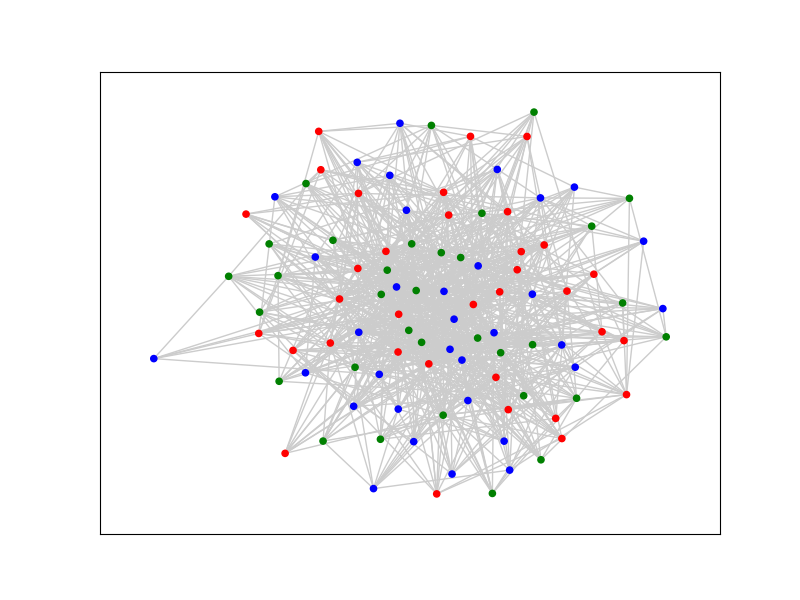

In [19]:
# graph
n_states = 100
p_state_classes = 3 * [1 / 3]
n_state_classes = len(p_state_classes)
graph = nx.barabasi_albert_graph(n_states, int(n_states * 0.10))
adjacency_matrix = np.asarray(nx.to_numpy_array(graph))
state_classes = np.zeros(n_states, dtype=int)
for i in range(n_states):
    state_classes[i] = np.arange(n_state_classes, dtype=int)[np.mod(i, n_state_classes)]

plt.close()
plt.rcParams['figure.figsize'] = 8, 6

# visualize graph

colors=['r', 'b', 'g', 'y', 'm', 'c']
state_colors = []
for i in state_classes:
    state_colors.append(colors[i])

pos=nx.spring_layout(graph)
nodes = nx.draw_networkx_nodes(graph,pos, node_color=state_colors, node_size=20) 
nodes.set_edgecolor(state_colors)
edges = nx.draw_networkx_edges(graph,pos,edge_color="#CCCCCC") 
plt.show()
plt.savefig("network.png", dpi=300)


# hypotheses
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
hyp_groups_homo = tp_group_homo
next_homo = next_state.init_grouped_matrix( \
    group_assignment.walker, \
    tp_group_homo)

In [20]:
# transition matrices for walkers

tp_random = tp.random(adjacency_matrix, state_classes)
tp_links = tp.links(adjacency_matrix, state_classes)
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
tp_group_homo_weighted = tp.group_homo_weighted(4, adjacency_matrix, state_classes)

# get two more similar transition matrices for the two groups
tp_similar = np.array([tp_group_homo[0], tp_group_homo_weighted[1]])
hyp_similar = tp_similar


# hypotheses (single)

hyp_teleport = utils.norm1_2d(np.ones((n_states, n_states)))
hyp_links = utils.norm1_2d(adjacency_matrix)
hyp_red = utils.norm1_2d(tp_group_homo[0])
hyp_blue = utils.norm1_2d(tp_group_homo[1])

# hypotheses (groups)

hyp_groups_homo = tp_group_homo
hyp_groups_homo_weighted = tp_group_homo_weighted

hyp_groups_memory = np.array([hyp_links, hyp_groups_homo[0], hyp_groups_homo[1]])
hyp_groups_memory_weighted = np.array([hyp_links, hyp_groups_homo_weighted[0], hyp_groups_homo_weighted[1]])

# hypotheses (direct)

number_of_groups = [2,3]
hyp_cart_homo_weighted = tp.expand(hyp_groups_homo_weighted, number_of_groups, 0)
hyp_cart_memory_weighted = tp.expand(hyp_groups_memory_weighted, number_of_groups, 1)

hyp_cart_homo = tp.expand(hyp_groups_homo, number_of_groups, 0)
hyp_cart_memory = tp.expand(hyp_groups_memory, number_of_groups, 1)


# next_step functions for different walker types to determine their next move

next_random = next_state.init_matrix(\
        tp_random)

next_links = next_state.init_matrix(\
        tp_links)

next_homo = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo)

next_memory = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo[0], tp_group_homo[1]])

next_homo_weighted = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo_weighted)

next_memory_weighted = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo_weighted[0], tp_group_homo_weighted[1], tp_group_homo_weighted[2]])


# violet walkers: we consider violet walkers, where each transition based on the walkers inconsistency
def violet_group(walk, walker, adjacency_matrix, state_properties):
    group = np.random.choice(len(walker), p=walker)
    return group
next_violet = next_state.init_grouped_matrix(violet_group, tp_group_homo_weighted)

next_similar = next_state.init_grouped_matrix(group_assignment.walker, tp_similar)
next_violet_similar = next_state.init_grouped_matrix(violet_group, tp_similar)

In [116]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, kappa=1000, smoothing=1, n_samples=10):
    group_assignment_p_curr = np.repeat(np.array([curr_state]), n_random_walkers * n_steps, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp_groups_homo)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)

    return log_likelihood_curr, prior.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=100, c2=100):
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    return proposed_state, proposal_ratio

# 100 walkers [0.6, 0.3, 0.1] data

In [101]:
# walker data
n_random_walkers = 100
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])
print(random_walker_class_counts)

[60 30 10]


In [147]:
# walker data
n_random_walkers = 1000
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions2 = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])
print(random_walker_class_counts)

[600 300 100]


In [24]:
# walker data
n_random_walkers = 3000
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions3 = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])
print(random_walker_class_counts)

[1800  900  300]


## Data Visualization

In [9]:
import trails.mtmc.ml.direct.optimized as directo

kappas_base = [0, 0.001,0.003, 0.01, 0.03, 0.1, 0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]

def run_exp(group_assignment_p, hyp, data):
    return {"x": kappas_base, "y": [directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * k for a in hyp]),
        smoothing = 1,
        n_samples = 10) for k in kappas_base]}

def run_exp2(group_assignment_p, hyp, data, kappa):
    return directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * kappa for a in hyp]),
        smoothing = 1,
        n_samples = 10)

In [154]:
ps = [0.5, 0.6, 0.7]
qs = [0.2, 0.3, 0.4]

experiments = OrderedDict()
for p in ps:
    for q in qs:
        if 1-p-q >= 0:
            p_dist = np.array([np.round(p, 2), np.round(q, 2), np.round(1-p-q, 2)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments[f"ɣ={p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions2)
        else: continue
            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

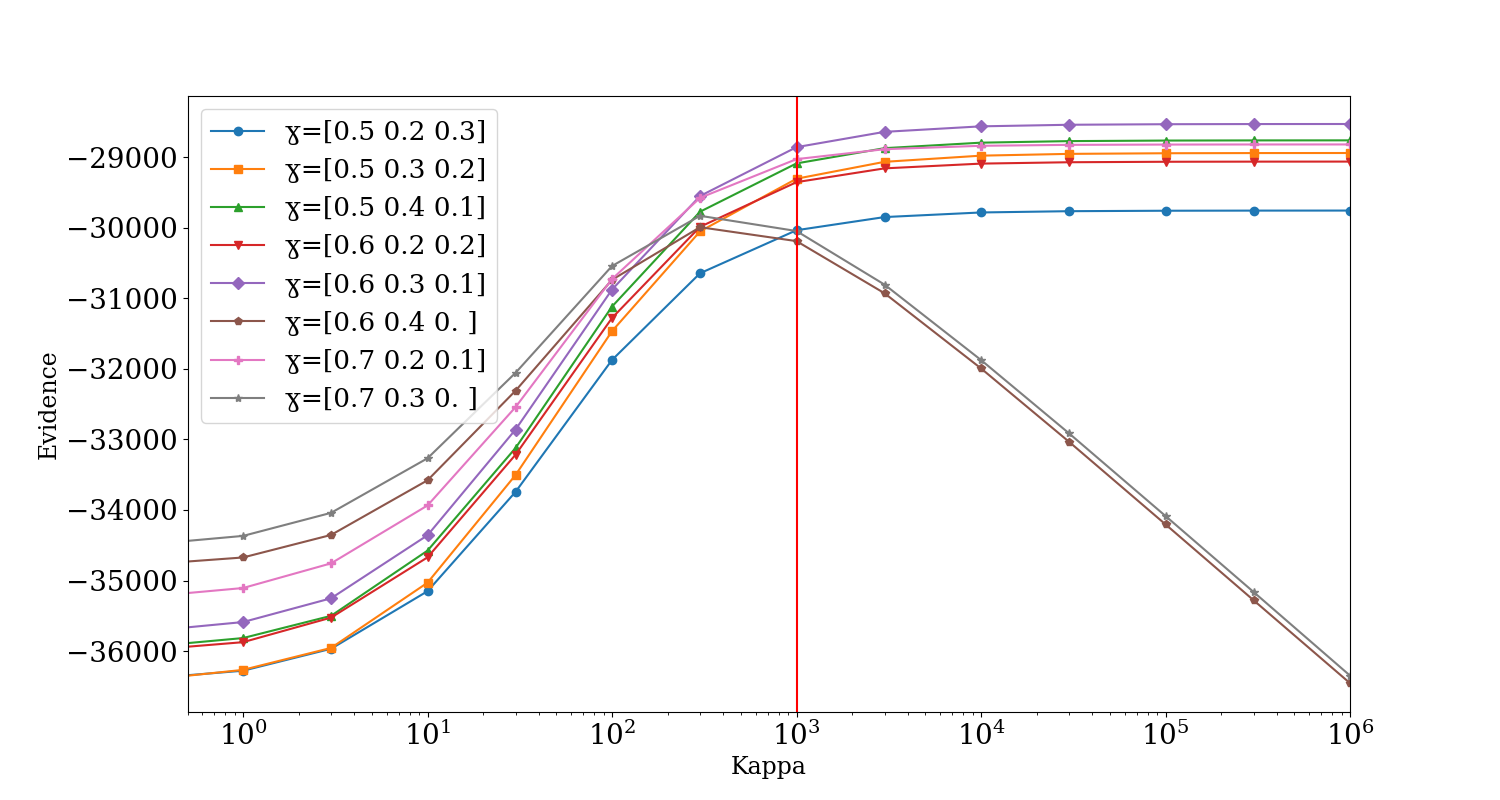

In [156]:
plt.rcParams['figure.figsize'] = 15, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = 10*['solid'] + ['dotted']

alphas = [0.3, 0.3, 0.3, 0.3, 1, 0.3, 0.3, 0.3]
alphas = 8* [1]

plt.close()
for idx, (key, data) in enumerate(experiments.items()):
    #print(key)
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key, alpha=alphas[idx])  # Plot 'x' vs 'y' using the current key as the label

plt.axvline(x=1000, color='red', linestyle='solid')
plt.xlim(0.5, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappa', fontsize=17)  # Set X-axis label
plt.ylabel('Evidence', fontsize=17)  # Set Y-axis label
plt.tick_params( labelsize=20)
plt.legend(loc='upper left',prop={'size': 19})  
plt.savefig("data_vis.png", dpi=200)
plt.show()  

In [11]:
ps = [0.5, 0.6, 0.7]
qs = [0.2, 0.3, 0.4]

experiments2 = OrderedDict()
for p in ps:
    for q in qs:
        if 1-p-q >= 0:
            p_dist = np.array([np.round(p, 2), np.round(q, 2), np.round(1-p-q, 2)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments2[f"ɣ={p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions2)
        else: continue
            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

C:\Users\Max\AppData\Local\Temp\ipykernel_16936\3074549846.py:15: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, max(data['x']))


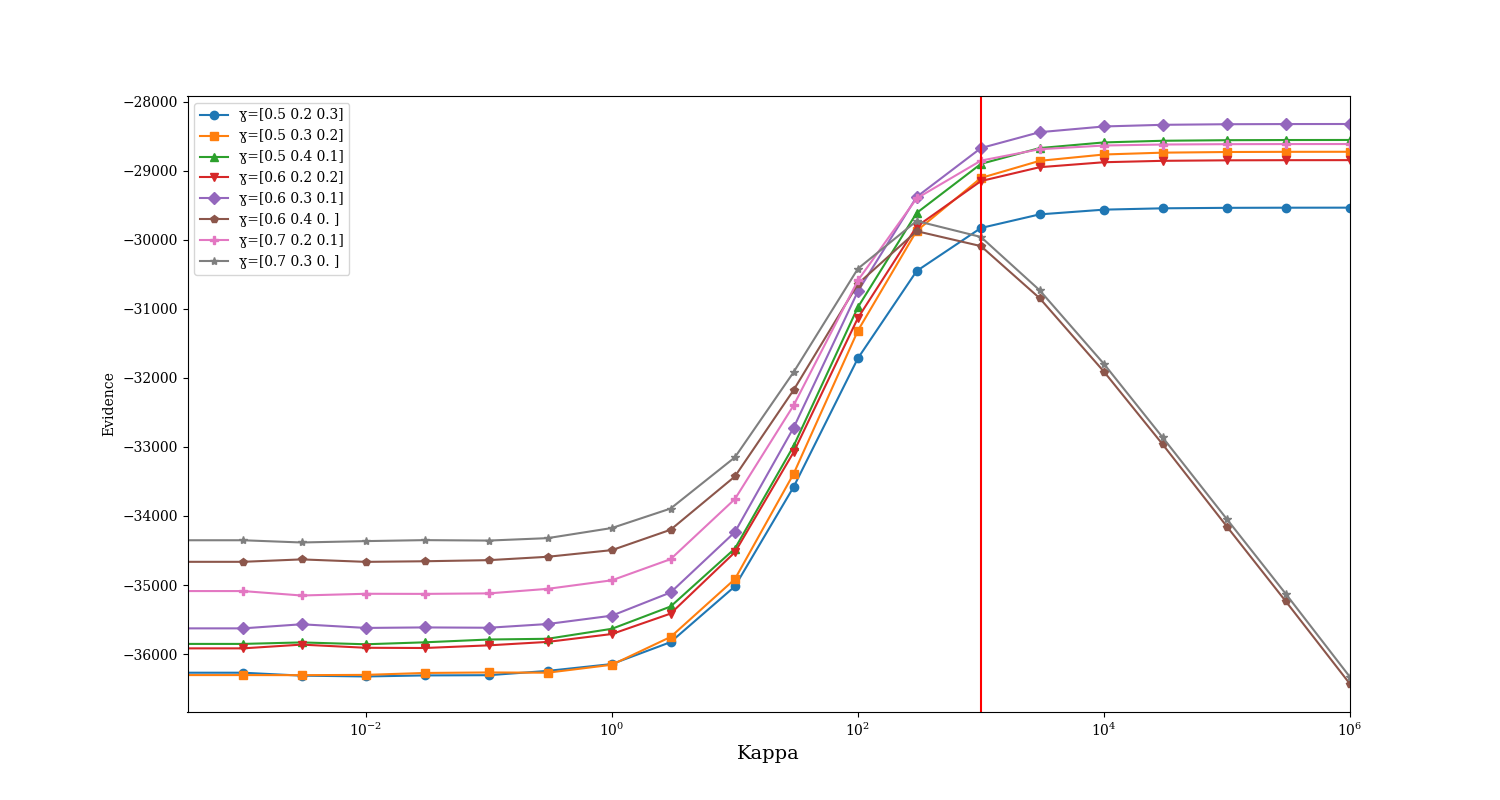

In [23]:
plt.rcParams['figure.figsize'] = 15, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = 10*['solid'] + ['dotted']

alphas = [0.3, 0.3, 0.3, 0.3, 1, 0.3, 0.3, 0.3]
alphas = 8* [1]

plt.close()
for idx, (key, data) in enumerate(experiments2.items()):
    #print(key)
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key, alpha=alphas[idx])  # Plot 'x' vs 'y' using the current key as the label

plt.axvline(x=1000, color='red', linestyle='solid')
plt.xlim(0, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappa', fontsize=14)  # Set X-axis label
plt.ylabel('Evidence')  # Set Y-axis label
#plt.title('Evidence for Different Group Assignment Probabilities')  
plt.legend()  
plt.savefig("data_vis_1000.png", dpi=300)
plt.show()  

In [13]:
ps = [0.5, 0.6, 0.7]
qs = [0.2, 0.3, 0.4]

experiments3 = OrderedDict()
for p in ps:
    for q in qs:
        if 1-p-q >= 0:
            p_dist = np.array([np.round(p, 2), np.round(q, 2), np.round(1-p-q, 2)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments3[f"ɣ={p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions3)
        else: continue
            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

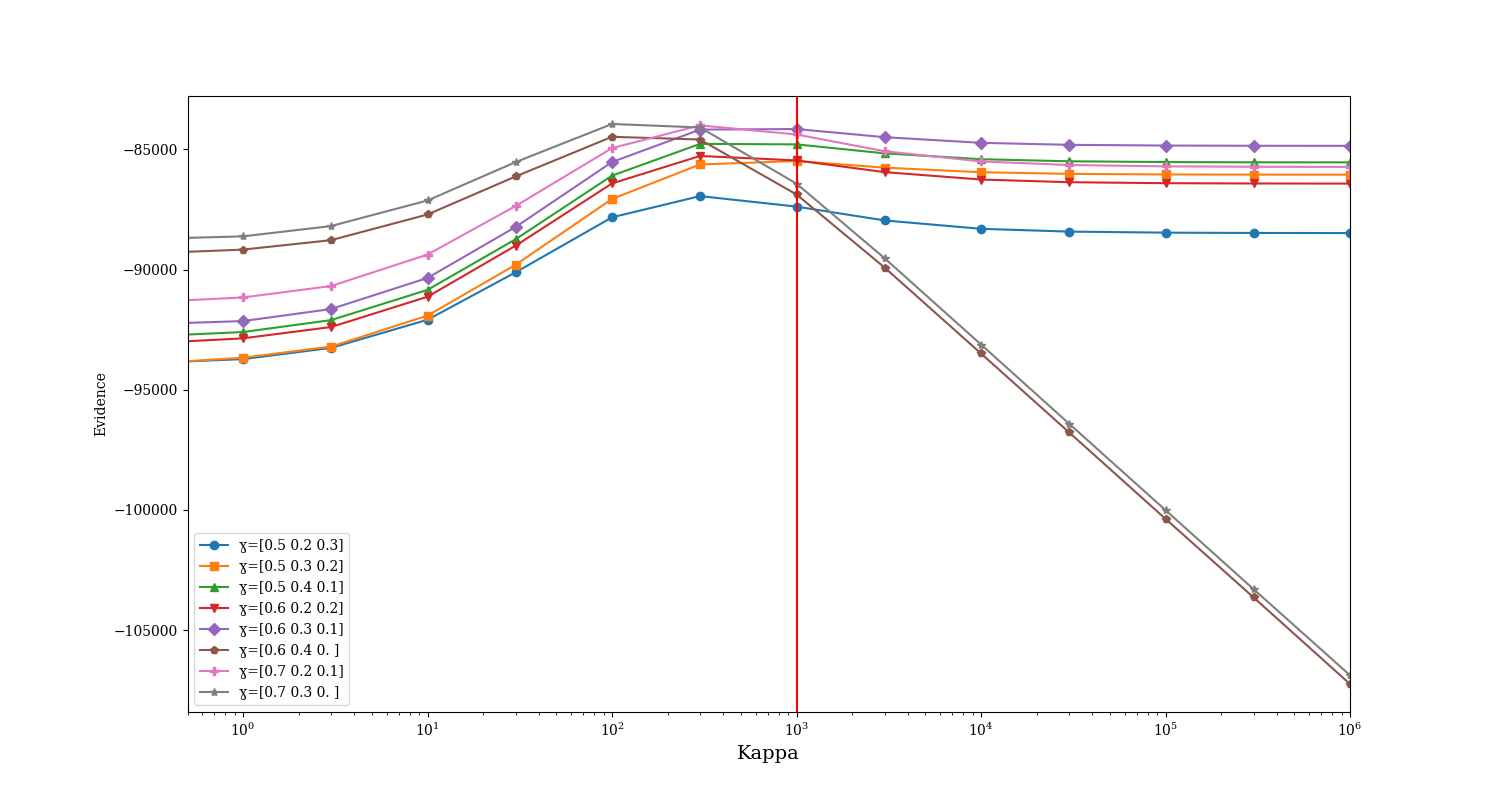

In [24]:
plt.rcParams['figure.figsize'] = 15, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = 10*['solid'] + ['dotted']

alphas = [0.3, 0.3, 0.3, 0.3, 1, 0.3, 0.3, 0.3]
alphas = 8* [1]

plt.close()
for idx, (key, data) in enumerate(experiments3.items()):
    #print(key)
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key, alpha=alphas[idx])  # Plot 'x' vs 'y' using the current key as the label

plt.axvline(x=1000, color='red', linestyle='solid')
plt.xlim(0.5, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappa', fontsize=14)  # Set X-axis label
plt.ylabel('Evidence')  # Set Y-axis label
#plt.title('Evidence for Different Group Assignment Probabilities')  
plt.legend()  
plt.savefig("data_vis_3000.png", dpi=300)
plt.show()  

In [104]:
# the group assignment probability is the same for each transition

ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
qs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

k = 1000

experiments_1 = pd.DataFrame(np.nan, index=ps, columns=qs)
for p in ps:
    for q in qs:
        if round(1-p-q, 1) >= 0:
            p_dist = np.array([p, q, round(1-p-q, 1)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments_1.loc[p, q] = run_exp2(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions, k)
        else: continue

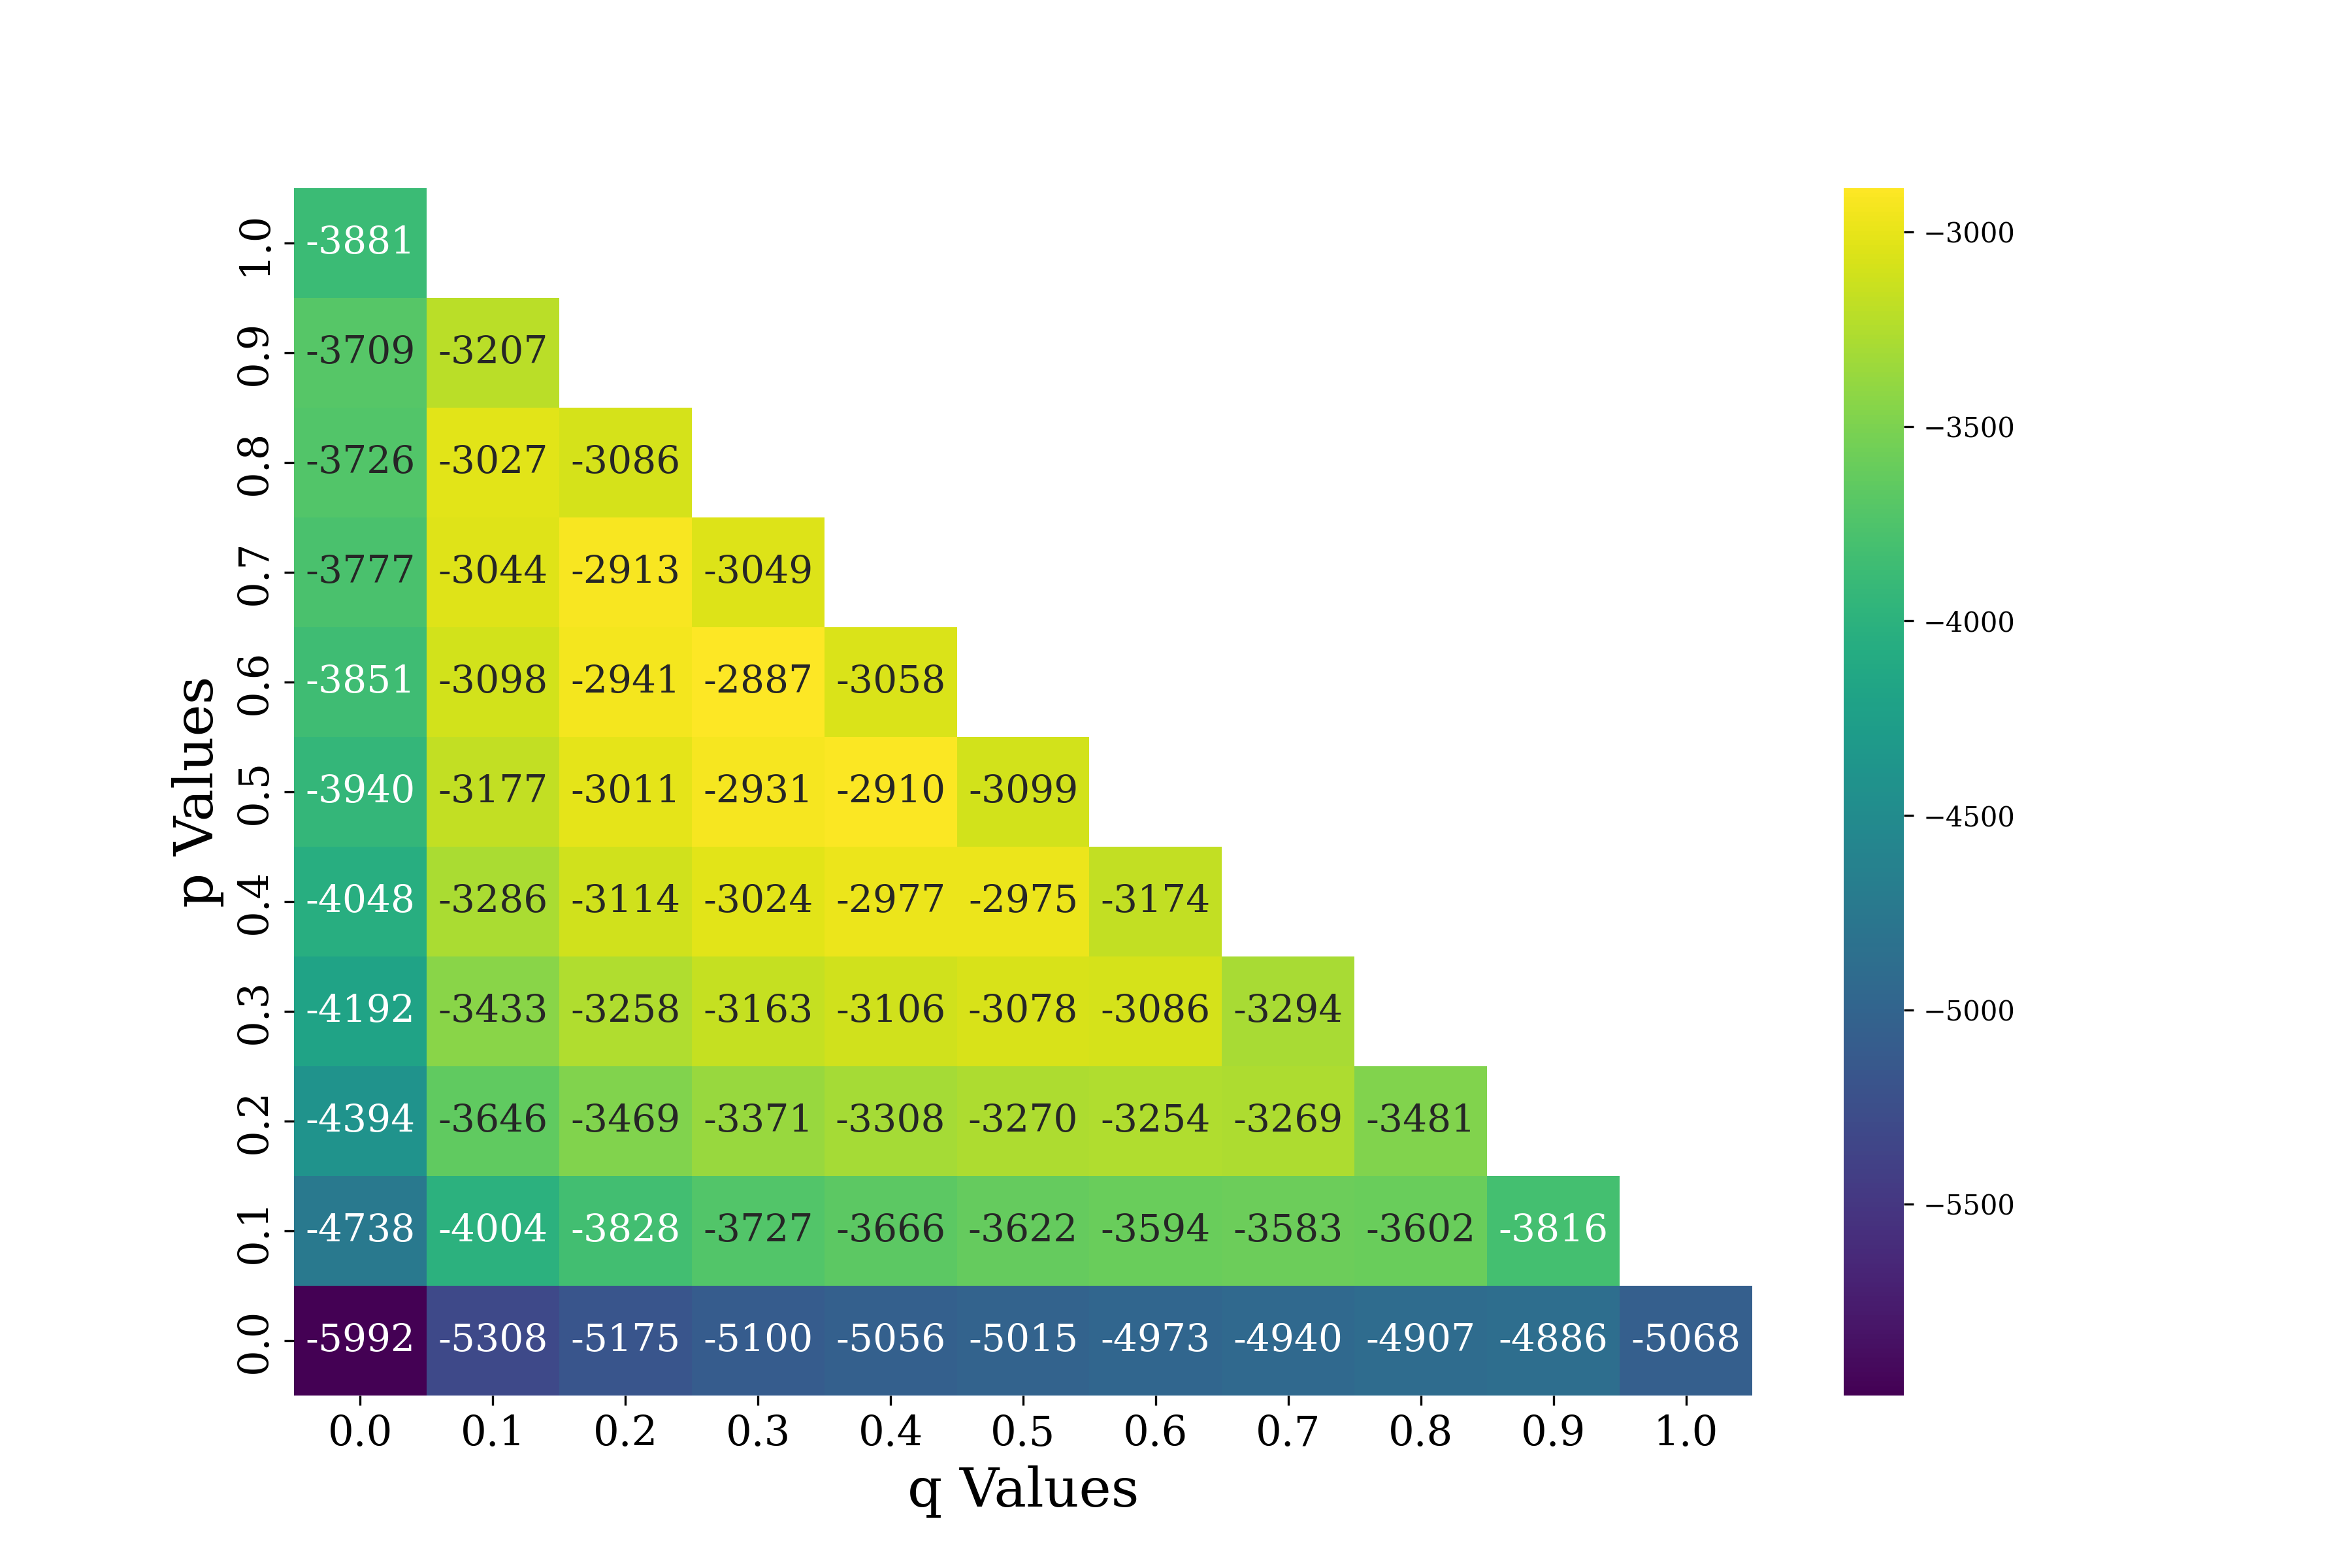

In [136]:
plt.close()
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(experiments_1.reindex(index=experiments_1.index[::-1]), annot=True, cmap='viridis', fmt=".0f", annot_kws={"fontsize":14})
plt.tick_params( labelsize=15)
#plt.title('Heatmap of Experiment Results')
plt.xlabel('q Values', fontsize=20)
plt.ylabel('p Values', fontsize=20)
plt.show()

# Metropolis Hastings

In [102]:
# init prior distribution
a = np.array([1, 1, 1])
prior = dirichlet(a)

### 1.000 MH samples

In [125]:
%%time

init_state = np.random.dirichlet(np.ones(3))
print(init_state)
init_state = np.array([0.03, 0.2, 0.77])
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 3000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array = np.array(samples)
burnin_samples_array = np.array(burnin_samples)

[0.46956073 0.01484144 0.51559783]
[array([0.60847331, 0.29648162, 0.09504507]), -2886.7503358782606]
532
CPU times: total: 3min 21s
Wall time: 3min 31s


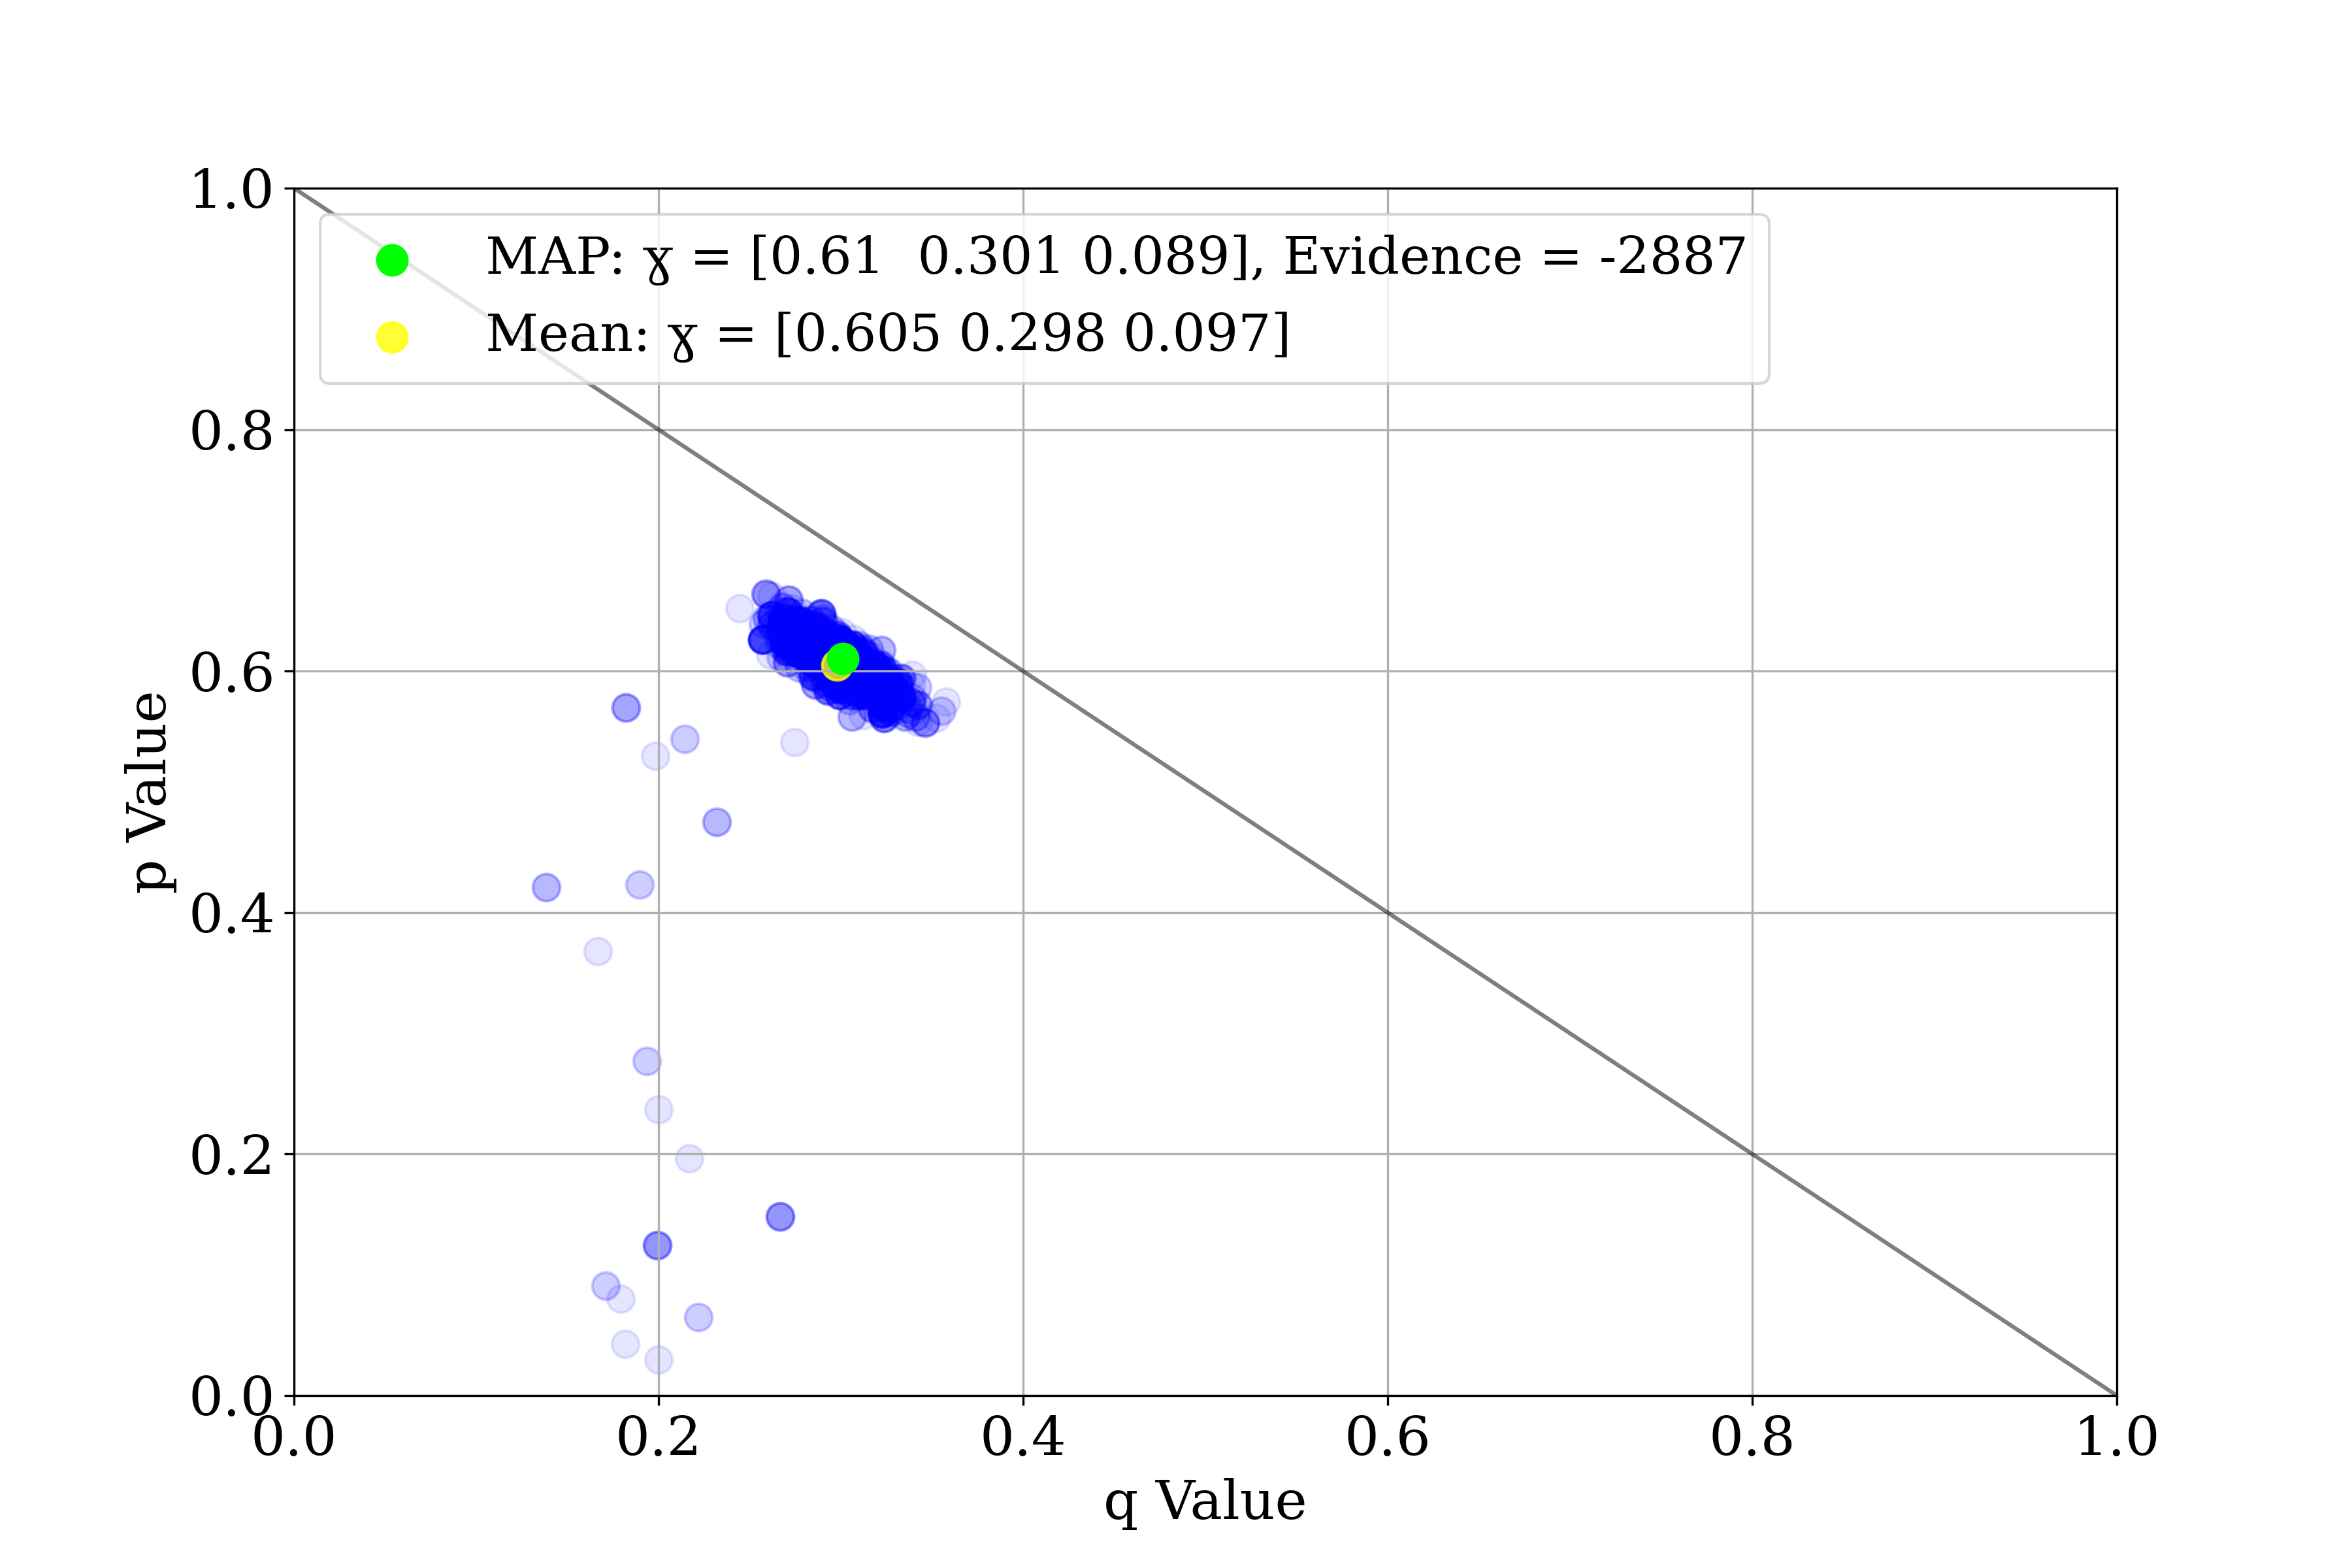

In [135]:
# Function to plot the samples with the specified index
plt.close()
fig1, ax1 = plt.subplots(dpi=300)
fig1.set_size_inches(12, 8)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array, samples_array))
    ax = ax1
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params( labelsize=20)
    #ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('q Value', fontsize=20)
    ax.set_ylabel('p Value', fontsize=20)
    ax.grid(True)

    maps = np.zeros(len(map_estimate_list) - sample_index)
    for i, entry in zip(np.arange(len(map_estimate_list) - sample_index), map_estimate_list[sample_index:]):
        maps[i] = map_estimate_list[i][1]
    idx = np.argmax(maps)
    map = map_estimate_list[idx]
    evidence = map[1]
    map = map[0]
    ax.scatter(map[1], map[0], s=120, c='lime', alpha=1, label=f'MAP: ɣ = {np.round(map,3)}, Evidence = {int(np.floor(evidence))}', zorder=5)
    
    ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=100, c='red', alpha=0.1)#, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=100, c='blue', alpha=0.1)
    
    # plot mean    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(curr_mean[1], curr_mean[0], s=120, c='yellow', alpha=0.8, label=f'Mean: ɣ = {curr_mean}')

    
    ax.legend(loc='upper left', fontsize="19")
    ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array, samples_array))) - 1))

# Noise

### Base Walkers

In [157]:
# walker data
n_random_walkers_base = 80
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers_base, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers_base).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks_base = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)

### Noise Walkers (link 20%)

In [158]:
# noise data
random_walker_classes_noise = np.zeros(20, dtype=int)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks_noise = r.walk( 
    random_walker_classes_noise, 
    next_links, 
    keep_walking.init_fixed(n_steps),
    first_state.random)

walks = walks_base + walks_noise

transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])

In [159]:
ps = [0.5, 0.6, 0.7]
qs = [0.2, 0.3, 0.4]

experiments_link = OrderedDict()
for p in ps:
    for q in qs:
        if 1-p-q >= 0:
            p_dist = np.array([np.round(p, 2), np.round(q, 2), np.round(1-p-q, 2)])
            group_assignment_p = np.repeat(np.array([p_dist]), (n_random_walkers + 20) * n_steps, axis=0)  
            experiments_link[f"ɣ={p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions)
        else: continue
            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

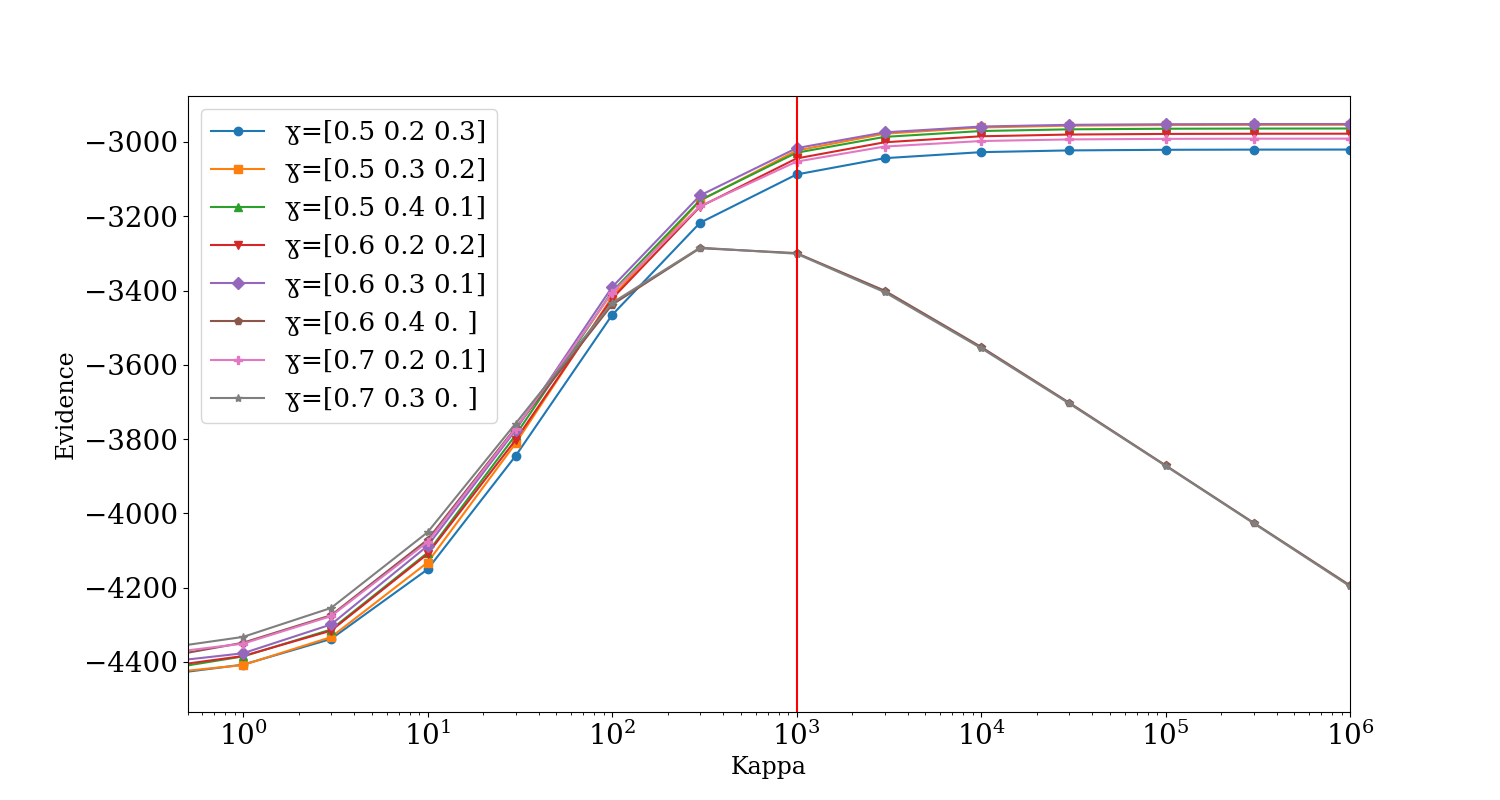

In [161]:
plt.rcParams['figure.figsize'] = 15, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = 10*['solid'] + ['dotted']

alphas = [0.3, 0.3, 0.3, 0.3, 1, 0.3, 0.3, 0.3]
alphas = 8* [1]

plt.close()
for idx, (key, data) in enumerate(experiments_link.items()):
    #print(key)
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key, alpha=alphas[idx])  # Plot 'x' vs 'y' using the current key as the label

plt.axvline(x=1000, color='red', linestyle='solid')
plt.xlim(0.5, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappa', fontsize=17)  # Set X-axis label
plt.ylabel('Evidence', fontsize=17)  # Set Y-axis label
plt.tick_params( labelsize=20)
plt.legend(loc='upper left',prop={'size': 19})  
plt.savefig("data_vis.png", dpi=300)
plt.show()  

In [36]:
%%time
init_state = np.random.dirichlet(np.ones(3))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list_2 = metropolis_hastings(init_state, calc_values, 3000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array_2 = np.array(samples)
burnin_samples_array_2 = np.array(burnin_samples)

[0.07215857 0.75200201 0.17583941]
[array([0.52995769, 0.3087393 , 0.16130301]), -3026.7272653855966]
126
CPU times: total: 2min 55s
Wall time: 3min 34s


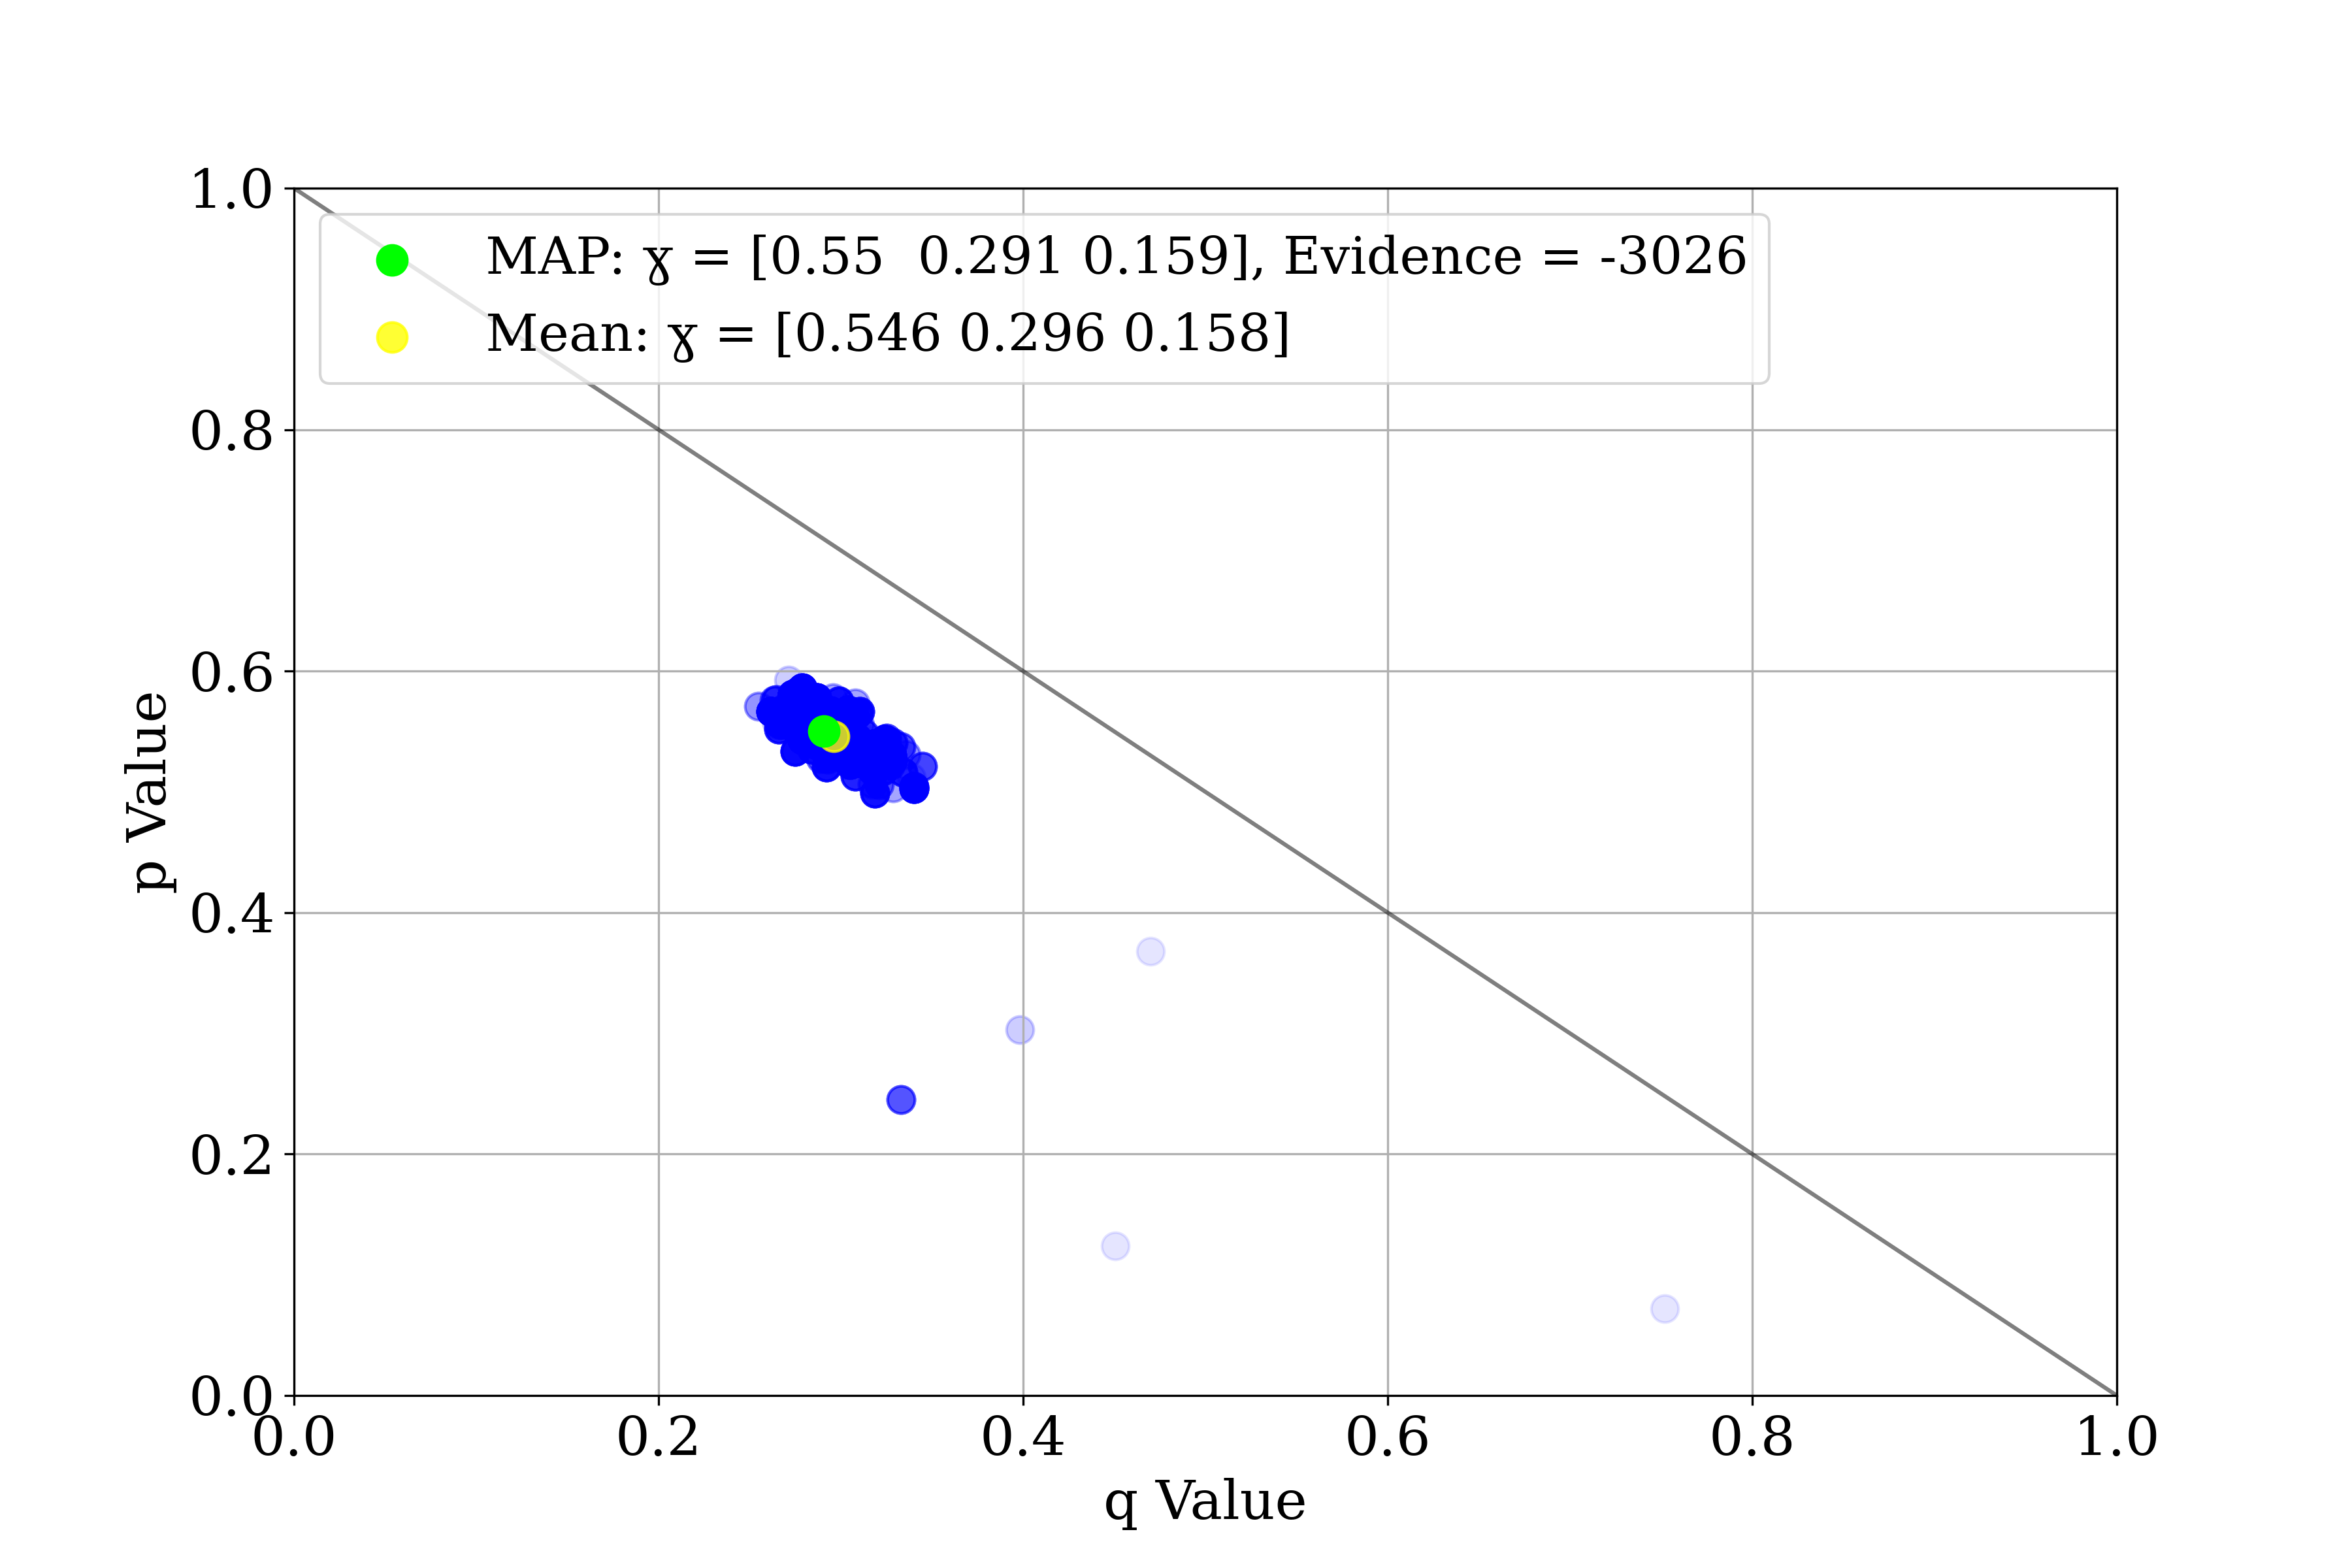

In [99]:
# Function to plot the samples with the specified index
plt.close()
fig2, ax2 = plt.subplots(dpi=300)
fig2.set_size_inches(12, 8)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array_2, samples_array_2))
    ax = ax2
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params( labelsize=20)
    #ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('q Value', fontsize=20)
    ax.set_ylabel('p Value', fontsize=20)
    ax.grid(True)

    maps = np.zeros(len(map_estimate_list_2) - sample_index)
    for i, entry in zip(np.arange(len(map_estimate_list_2) - sample_index), map_estimate_list_2[sample_index:]):
        maps[i] = map_estimate_list_2[i][1]
    idx = np.argmax(maps)
    map = map_estimate_list_2[idx]
    evidence = map[1]
    map = map[0]
    ax.scatter(map[1], map[0], s=120, c='lime', alpha=1, label=f'MAP: ɣ = {np.round(map,3)}, Evidence = {int(evidence)}', zorder=5)
    
    ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=100, c='red', alpha=0.1)#, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=100, c='blue', alpha=0.1)
    
    # plot mean    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(curr_mean[1], curr_mean[0], s=120, c='yellow', alpha=0.8, label=f'Mean: ɣ = {curr_mean}')

    
    ax.legend(loc='upper left', fontsize="19")
    ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array_2, samples_array_2))) - 1))

In [32]:
# the group assignment probability is the same for each transition

ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
qs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

k = 1000

experiments_2 = pd.DataFrame(np.nan, index=ps, columns=qs)
for p in ps:
    for q in qs:
        if round(1-p-q, 1) >= 0:
            p_dist = np.array([p, q, round(1-p-q, 1)])
            group_assignment_p = np.repeat(np.array([p_dist]), n_random_walkers * n_steps, axis=0)  
            experiments_2.loc[p, q] = run_exp2(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions, k)
        else: continue

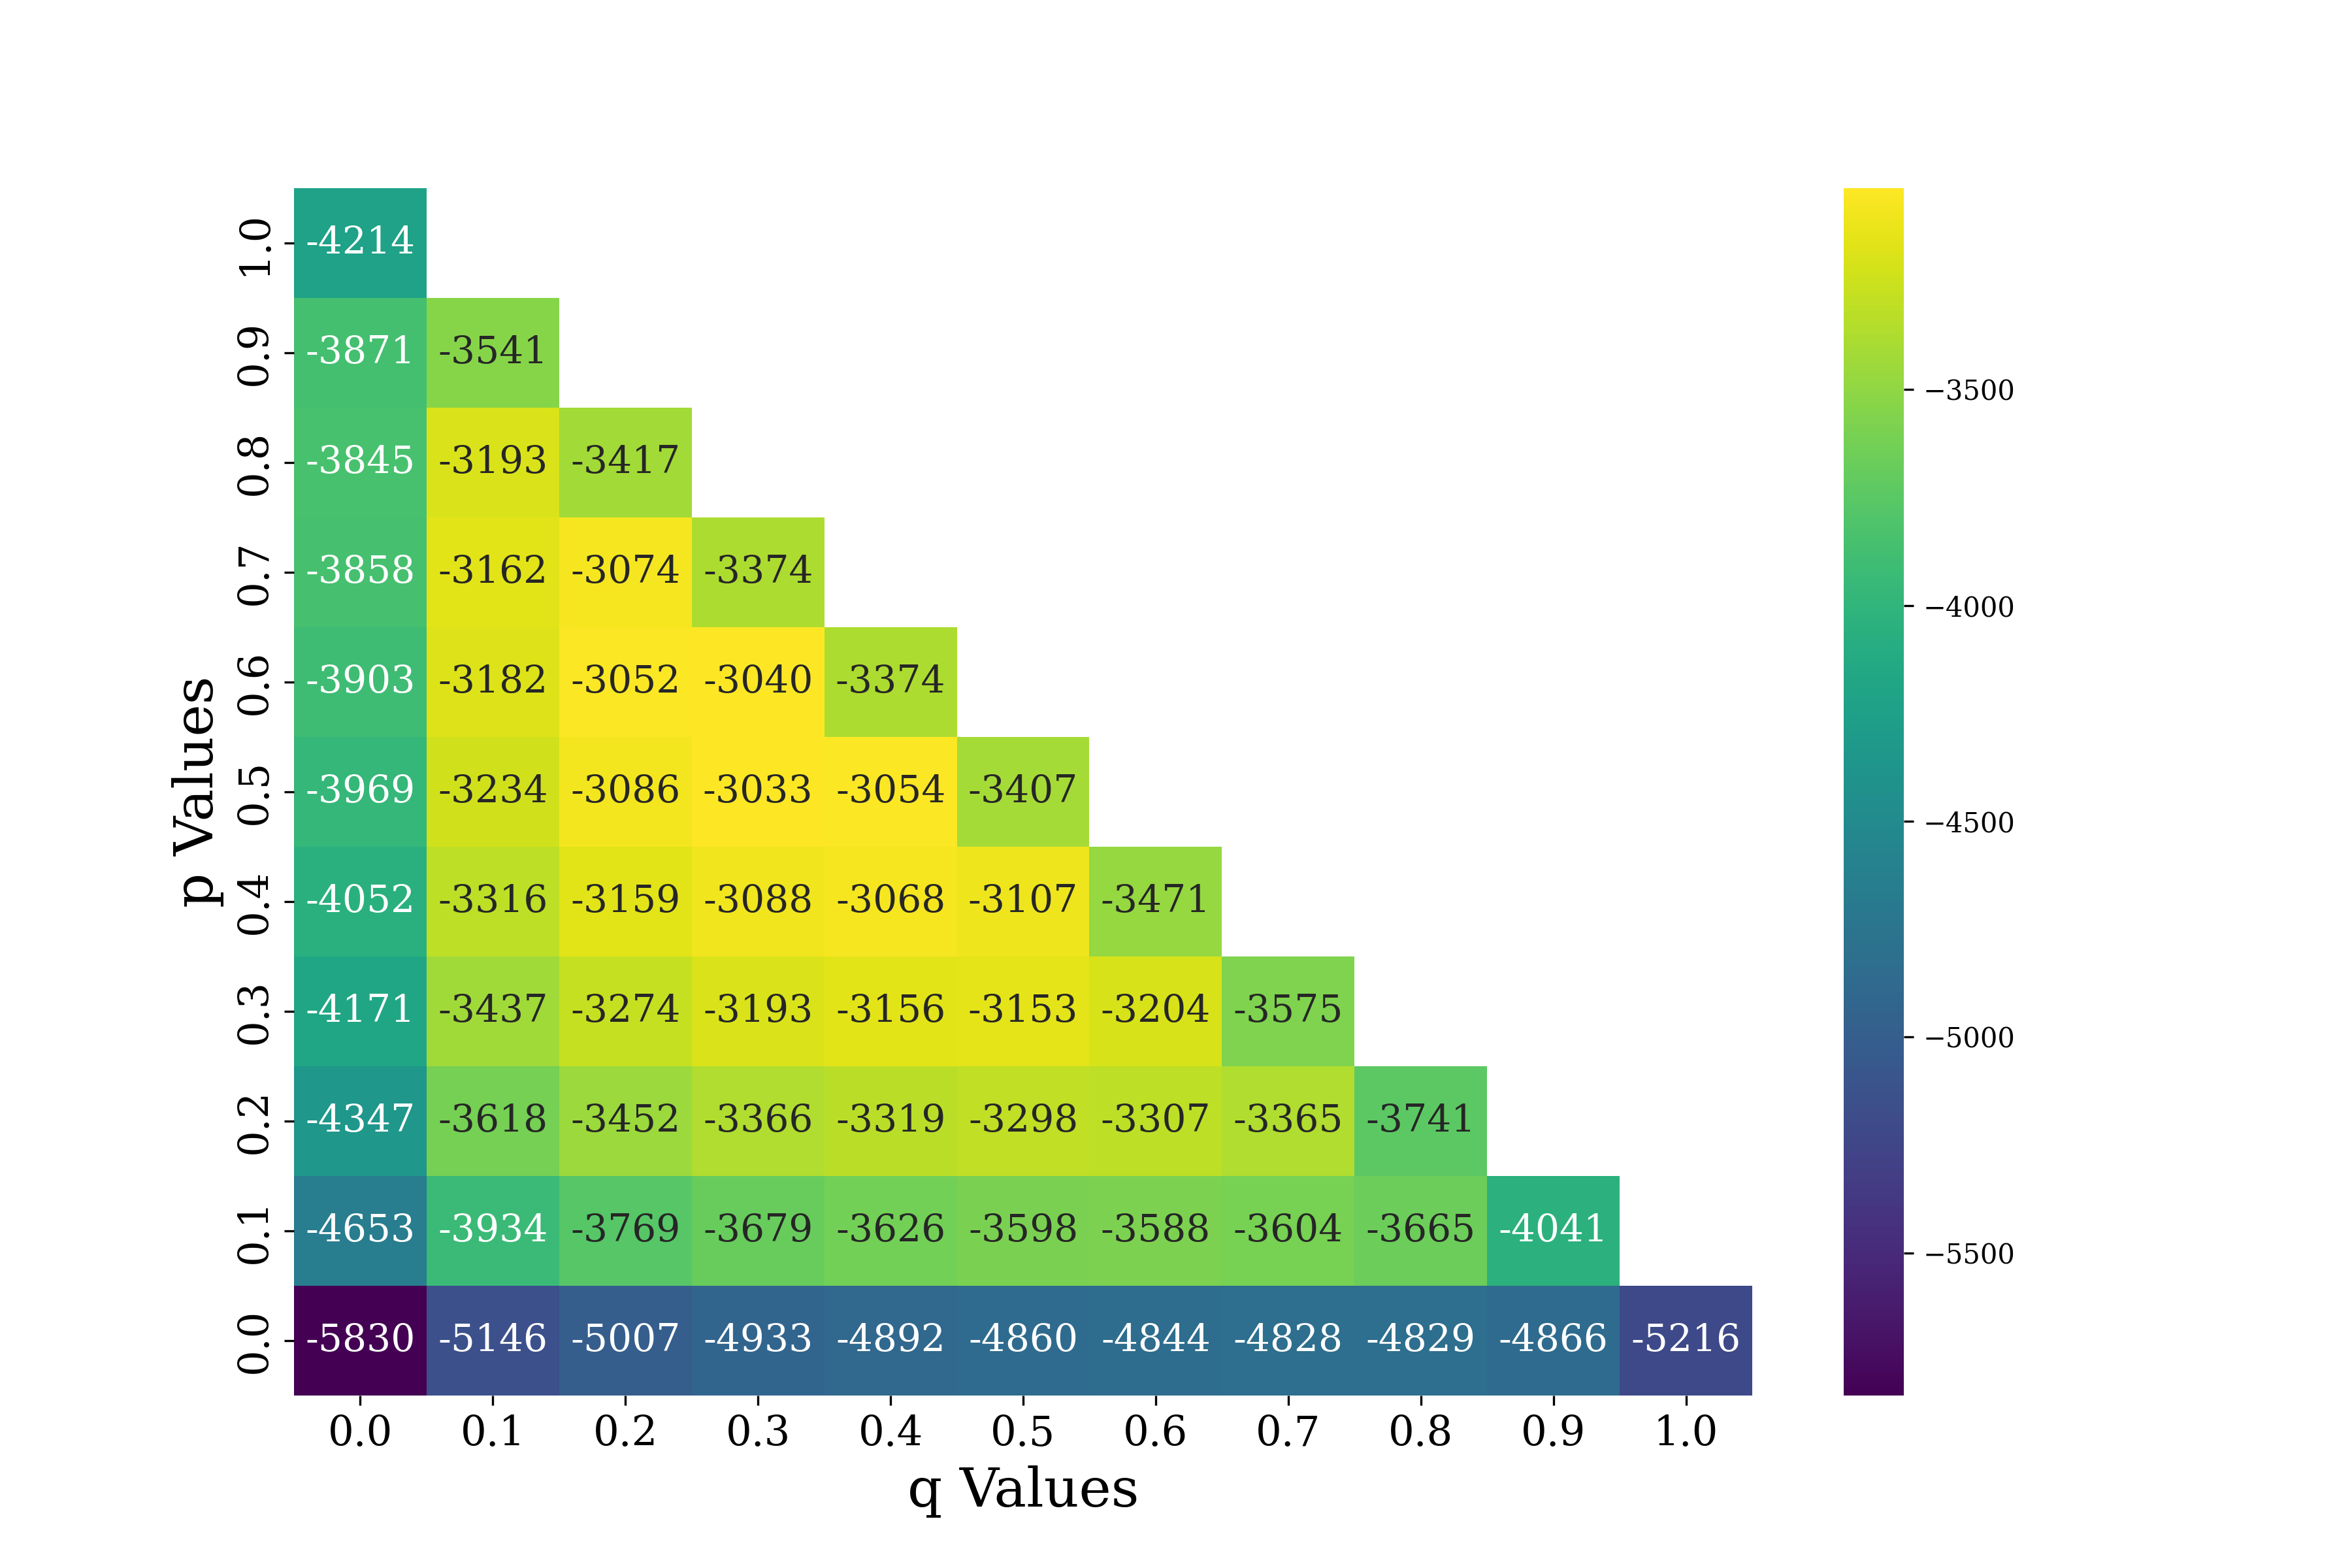

In [100]:

plt.close()
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(experiments_2.reindex(index=experiments_2.index[::-1]), annot=True, cmap='viridis', fmt=".0f", annot_kws={"fontsize":14})
plt.tick_params( labelsize=15)
#plt.title('Heatmap of Experiment Results')
plt.xlabel('q Values', fontsize=20)
plt.ylabel('p Values', fontsize=20)
plt.savefig("heatmap.png", dpi=300)
plt.show()

### Noise Walkers (teleport 20%)

In [162]:
# noise data
random_walker_classes_noise = np.zeros(20, dtype=int)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks_noise = r.walk( 
    random_walker_classes_noise, 
    next_random, 
    keep_walking.init_fixed(n_steps),
    first_state.random)

walks = walks_base + walks_noise

transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])

In [163]:
ps = [0.5, 0.6, 0.7]
qs = [0.2, 0.3, 0.4]

experiments_tele = OrderedDict()
for p in ps:
    for q in qs:
        if 1-p-q >= 0:
            p_dist = np.array([np.round(p, 2), np.round(q, 2), np.round(1-p-q, 2)])
            group_assignment_p = np.repeat(np.array([p_dist]), (n_random_walkers + 20) * n_steps, axis=0)  
            experiments_tele[f"ɣ: {p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions)
        else: continue
            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

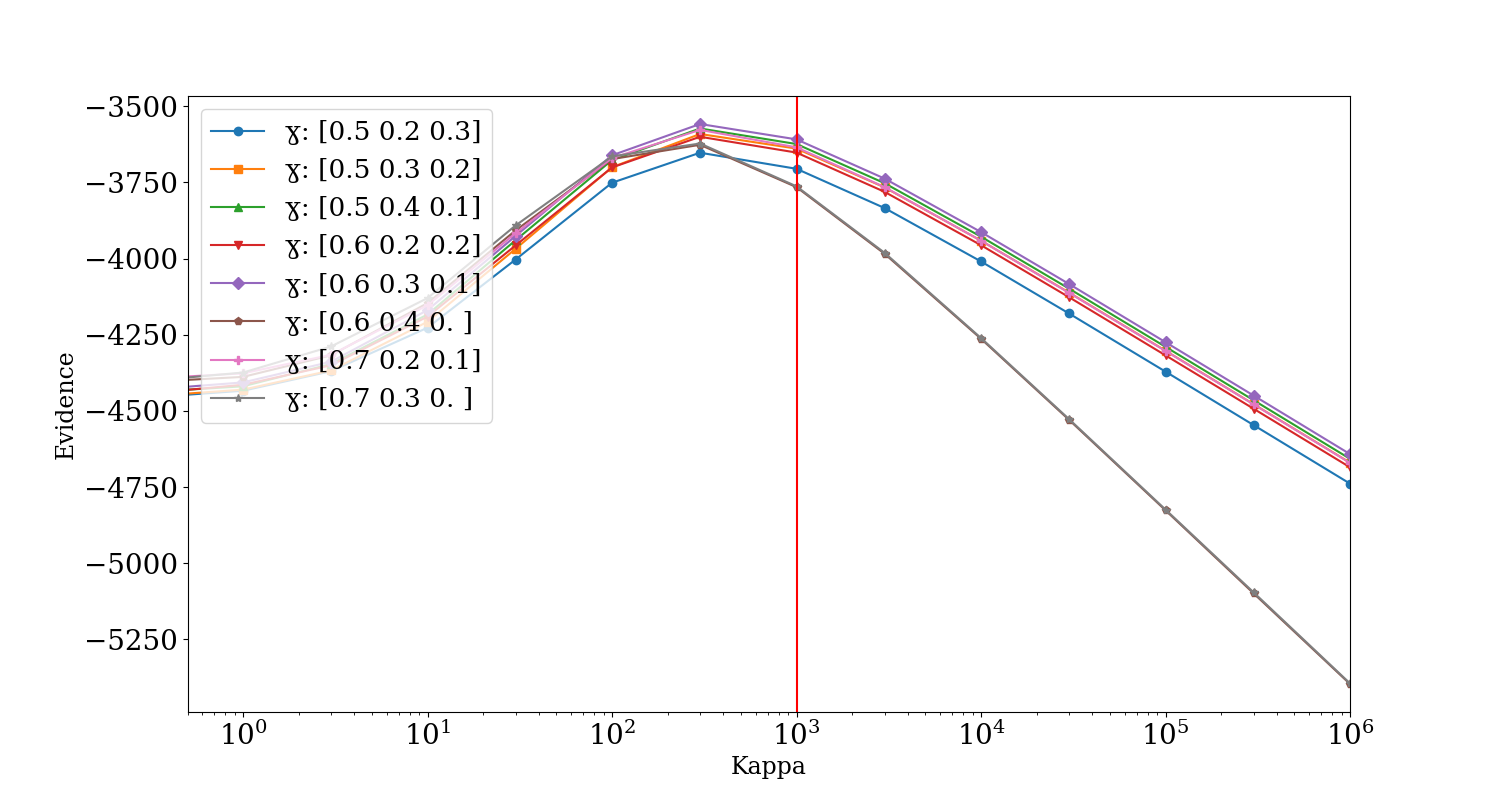

In [164]:
plt.rcParams['figure.figsize'] = 15, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = 10*['solid'] + ['dotted']

alphas = [0.3, 0.3, 0.3, 0.3, 1, 0.3, 0.3, 0.3]
alphas = 8* [1]

plt.close()
for idx, (key, data) in enumerate(experiments_tele.items()):
    #print(key)
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key, alpha=alphas[idx])  # Plot 'x' vs 'y' using the current key as the label

plt.axvline(x=1000, color='red', linestyle='solid')
plt.xlim(0.5, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappa', fontsize=17)  # Set X-axis label
plt.ylabel('Evidence', fontsize=17)  # Set Y-axis label
plt.tick_params( labelsize=20)
plt.legend(loc='upper left',prop={'size': 19})  
plt.savefig("data_vis.png", dpi=300)
plt.show()  

In [39]:
# walker data
n_random_walkers_base = 800
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers_base, p_dist)
random_walker_class_counts = np.array(np.array(p_dist) * n_random_walkers_base).astype(int)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks_base = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)

In [41]:
# noise data
random_walker_classes_noise = np.zeros(200, dtype=int)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks_noise = r.walk( 
    random_walker_classes_noise, 
    next_random, 
    keep_walking.init_fixed(n_steps),
    first_state.random)

walks = walks_base + walks_noise

transitions2 = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])

In [43]:
ps = [0.5, 0.6, 0.7]
qs = [0.2, 0.3, 0.4]

experiments_tele2 = OrderedDict()
for p in ps:
    for q in qs:
        if 1-p-q >= 0:
            p_dist = np.array([p, q, 1-p-q])
            group_assignment_p = np.repeat(np.array([p_dist]), (n_random_walkers_base + 200) * n_steps, axis=0)  
            experiments_tele2[f"p_dist: {p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_groups_homo), transitions2)
        else: continue
            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

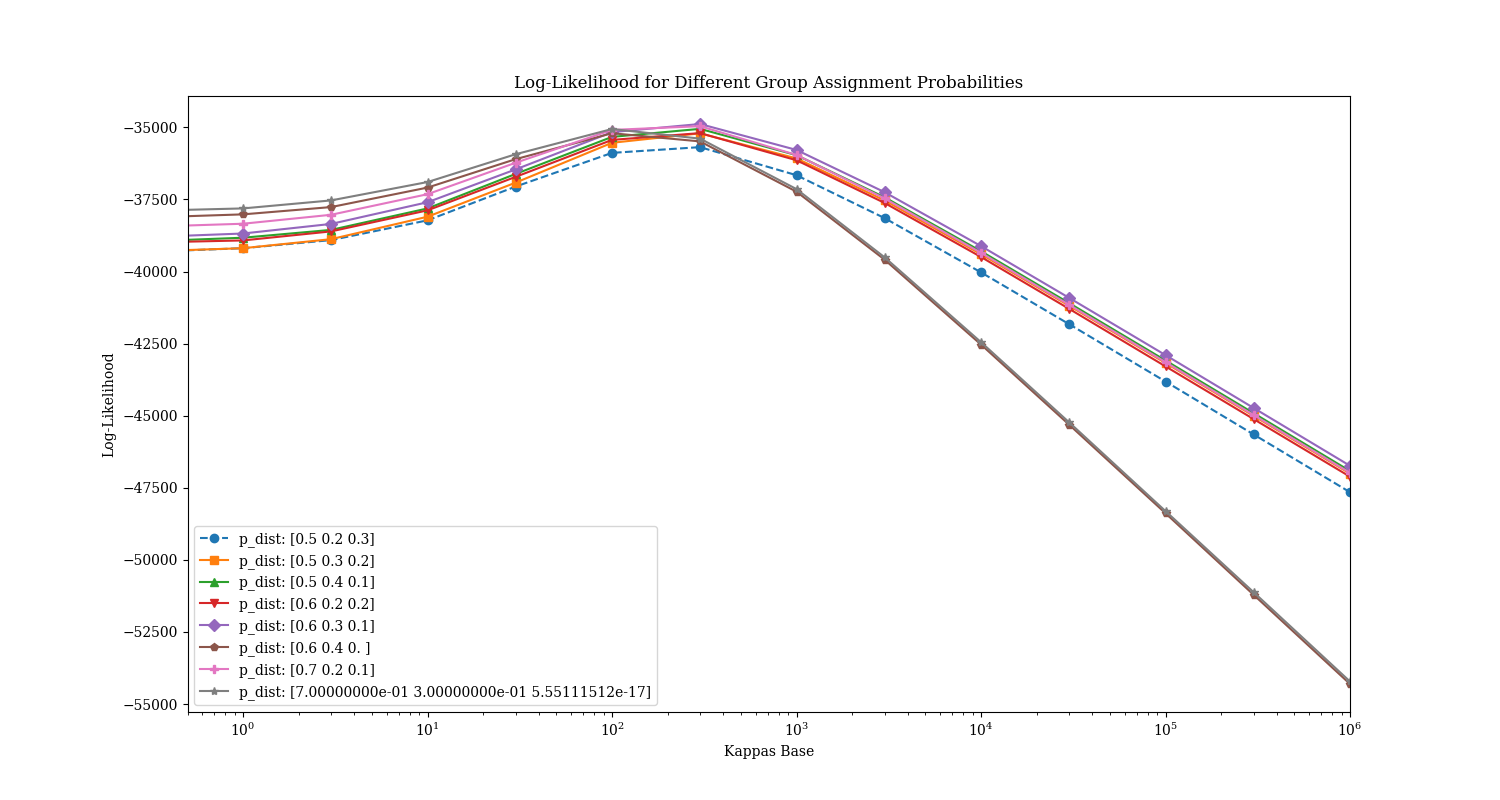

In [45]:
markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = ['dashed'] + 10*['solid'] + ['dotted']

plt.close()
for idx, (key, data) in enumerate(experiments_tele2.items()):
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key)  # Plot 'x' vs 'y' using the current key as the label

plt.xlim(0.5, max(data['x']))
#plt.ylim(-4500, -3400)
plt.xlabel('Kappas Base')  # Set X-axis label
plt.ylabel('Log-Likelihood')  # Set Y-axis label
plt.title('Log-Likelihood for Different Group Assignment Probabilities')  
plt.legend()  
plt.show()  

In [48]:
from scipy.special import gamma
from scipy.special import gammaln

counts1 = np.random.uniform(1000, 5000, 100)
counts2 = np.random.uniform(5000, 10000, 100)
counts3 = np.random.uniform(10000, 50000, 100)
counts4 = np.random.uniform(80000, 120000, 100)

alpha = np.random.uniform(1000, 5000, 100)

value = np.prod(gamma(counts1 + alpha)) / gamma(np.sum(counts1 + alpha))
np.sum(counts1 + alpha)

print(np.sum(gammaln(counts1 + alpha)) - gammaln(np.sum(counts1 + alpha)))
print(np.sum(gammaln(counts2 + alpha)) - gammaln(np.sum(counts2 + alpha)))
print(np.sum(gammaln(counts3 + alpha)) - gammaln(np.sum(counts3 + alpha)))
print(np.sum(gammaln(counts4 + alpha)) - gammaln(np.sum(counts4 + alpha)))

print(gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)))

-2752199.0444050916
-4753249.375129683
-15300898.538683265
-46759884.95416342
1320324.2059267391


C:\Users\Max\AppData\Local\Temp\ipykernel_18408\1020918846.py:11: RuntimeWarning: invalid value encountered in scalar divide
  value = np.prod(gamma(counts1 + alpha)) / gamma(np.sum(counts1 + alpha))


In [102]:
%%time

init_state = np.random.dirichlet(np.ones(3))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list_3 = metropolis_hastings(init_state, calc_values, 1000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array_3 = np.array(samples)
burnin_samples_array_3 = np.array(burnin_samples)

[0.53674931 0.03265741 0.43059328]
[array([0.58583049, 0.30746838, 0.10670113]), -3869.09174111332]
191
CPU times: total: 1min 20s
Wall time: 1min 21s


NameError: name 'burnin_samples_array_3' is not defined

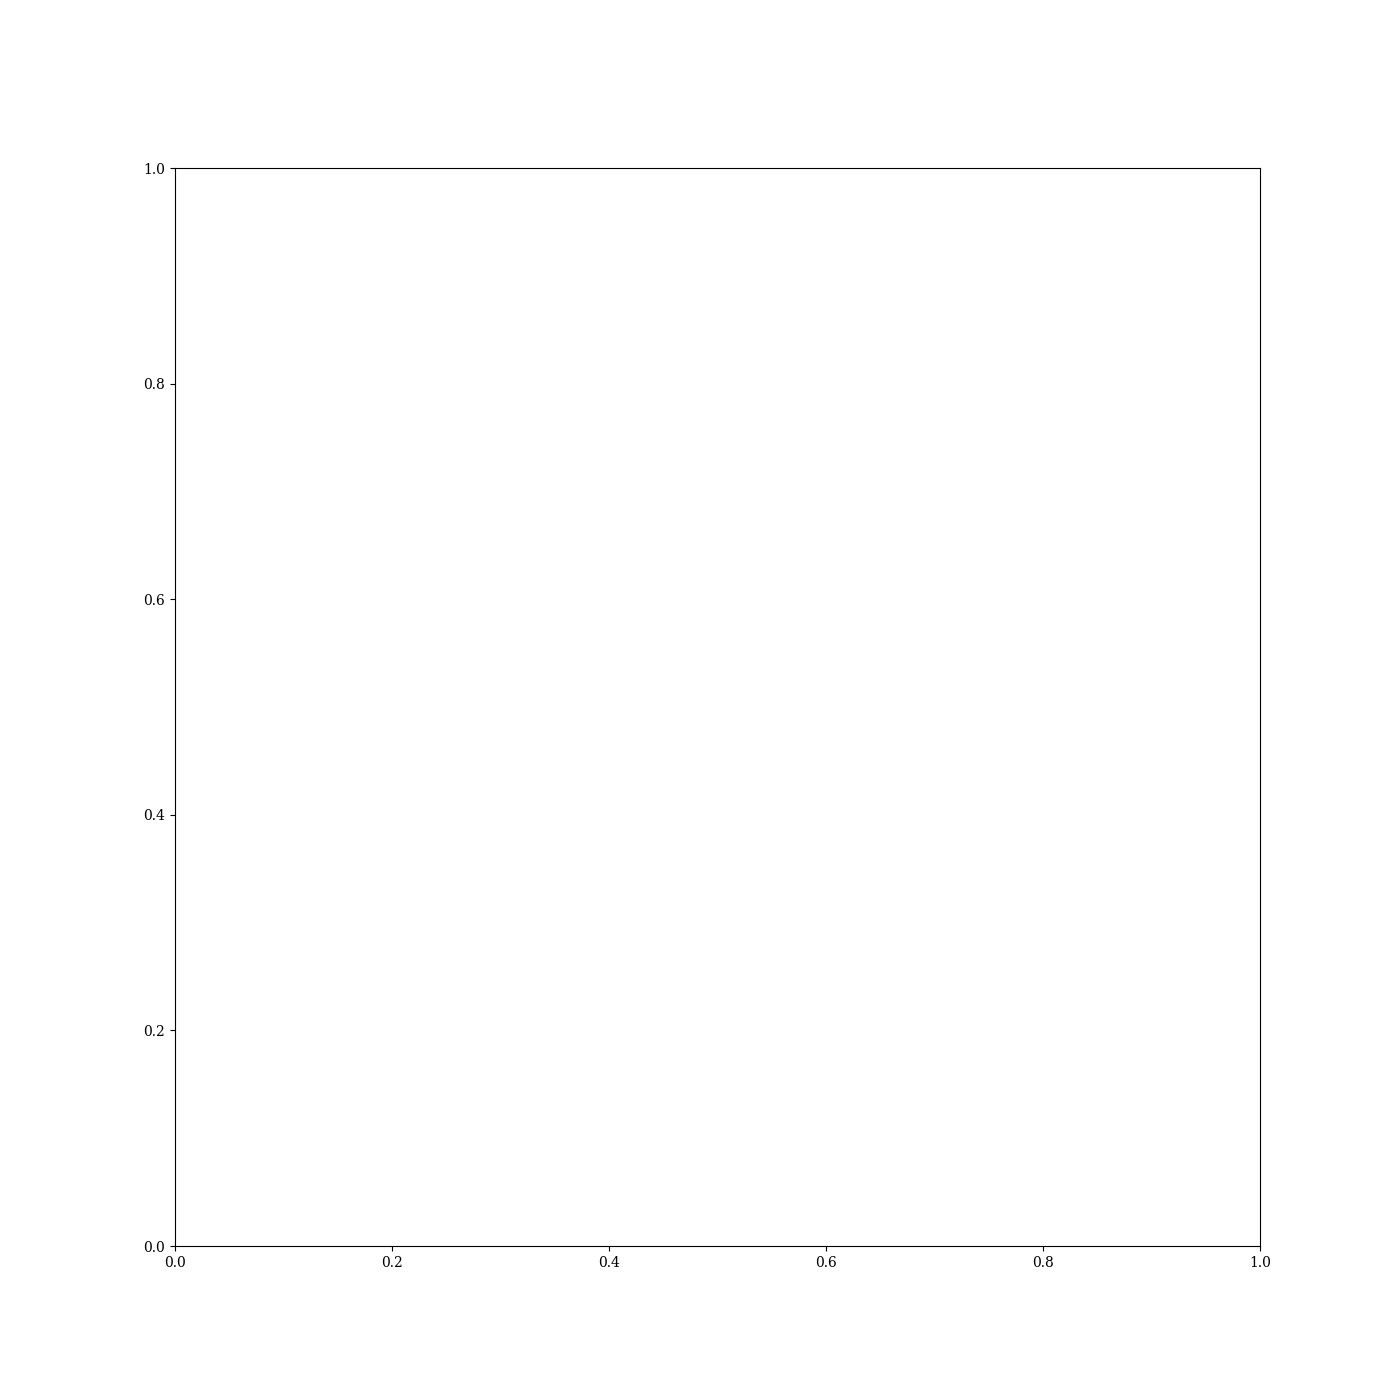

In [135]:
# Function to plot the samples with the specified index
plt.close()
fig3, ax3 = plt.subplots()
fig3.set_size_inches(14, 14)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array_3, samples_array_3))
    ax = ax3
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('q Value')
    ax.set_ylabel('p Value')
    ax.grid(True)
    

    ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=50, c='red', alpha=0.3)#, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 2)
    ax.scatter(curr_mean[1], curr_mean[0], s=50, c='yellow', alpha=0.8, label=f'Mean (of actual used): {curr_mean}')

    
    ax.scatter(map_estimate_list[sample_index][0][1], map_estimate_list[sample_index][0][0], s=50, c='lime', alpha=0.8, 
               label=f'MAP (of actual used): {np.round(map_estimate_list[sample_index][0],2)}, Log-Value: {np.round(map_estimate_list[sample_index][1])}')
    
    ax.legend(loc='upper left', fontsize="20")
    ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array_3, samples_array_3))) - 1))

# 1.000 walker [0.6, 0.3, 0.1] data

In [104]:
# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=1000, c2=100):
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    return proposed_state, proposal_ratio

In [105]:
# walker data
n_random_walkers = 1000
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])

In [106]:
%%time
init_state = np.random.dirichlet(np.ones(3))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list_4 = metropolis_hastings(init_state, calc_values, 100, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array_4 = np.array(samples)
burnin_samples_array_4 = np.array(burnin_samples)

[0.16267416 0.32468262 0.51264321]
[array([0.60960886, 0.30353473, 0.08685641]), -27630.354996898503]
47
CPU times: total: 46.7 s
Wall time: 47.4 s


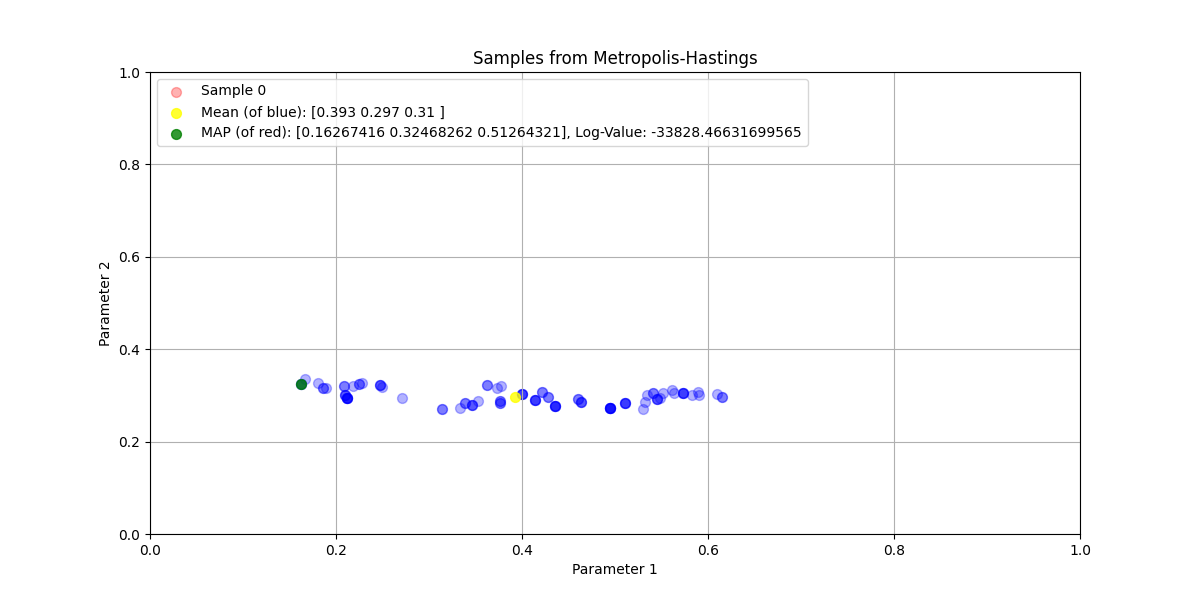

In [107]:
# Function to plot the samples with the specified index
plt.close()
fig4, ax4 = plt.subplots()
fig4.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array_4, samples_array_4))
    ax = ax4
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('Parameter 1')
    ax.set_ylabel('Parameter 2')
    ax.grid(True)

    ax.scatter(samps[:sample_index, 0], samps[:sample_index, 1], s=50, c='red', alpha=0.3, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 0], samps[sample_index:, 1], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(curr_mean[0], curr_mean[1], s=50, c='yellow', alpha=0.8, label=f'Mean (of blue): {curr_mean}')
    ax.scatter(map_estimate_list_4[sample_index][0][0], map_estimate_list_4[sample_index][0][1], s=50, c='green', alpha=0.8, 
               label=f'MAP (of red): {map_estimate_list_4[sample_index][0]}, Log-Value: {map_estimate_list_4[sample_index][1]}')
    
    
    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array_4, samples_array_4))) - 1))

higher concentration factor in the dirichlet proposal yields slower convergence, which makes sense because the proposed states lie closer to to last sample

# 10.000 walker [0.6, 0.3, 0.1] data

In [108]:
# walker data
n_random_walkers = 10000
n_steps = 10
p_dist = [0.6, 0.3, 0.1]
n_random_walker_classes = len(p_dist)
random_walker_class_counts = np.random.multinomial(n_random_walkers, p_dist)
random_walker_classes = np.repeat(range(n_random_walker_classes), random_walker_class_counts)

r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk(random_walker_classes, next_homo, keep_walking.init_fixed(n_steps), first_state.random)
transitions = np.concatenate([list(zip(walk[:-1], walk[1:])) for walker, walk in walks])

In [30]:
%%time
init_state = np.random.dirichlet(np.ones(3))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list_5 = metropolis_hastings(init_state, calc_values, 1000, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array_5 = np.array(samples)
burnin_samples_array_5 = np.array(burnin_samples)

[0.12930044 0.21928045 0.6514191 ]
[array([0.60896366, 0.29620446, 0.09483188]), -274824.15506464057]
86
CPU times: total: 47min 37s
Wall time: 47min 40s


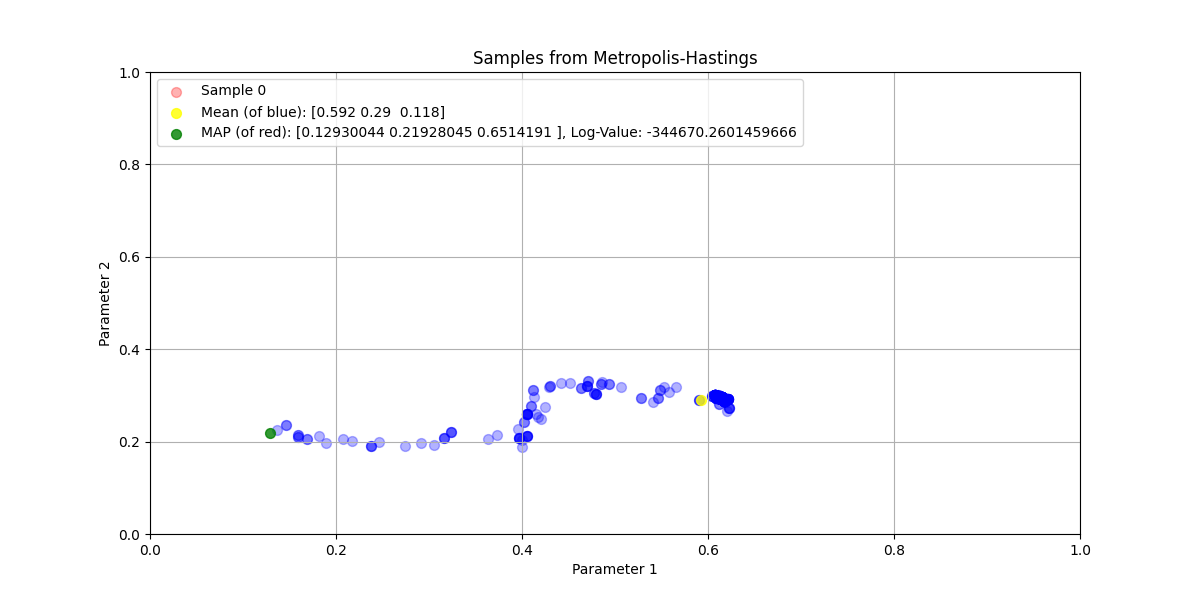

In [41]:
# Function to plot the samples with the specified index
plt.close()
fig5, ax5 = plt.subplots()
fig5.set_size_inches(12, 6)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array_5, samples_array_5))
    ax = ax5
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('Parameter 1')
    ax.set_ylabel('Parameter 2')
    ax.grid(True)

    ax.scatter(samps[:sample_index, 0], samps[:sample_index, 1], s=50, c='red', alpha=0.3, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 0], samps[sample_index:, 1], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    ax.scatter(curr_mean[0], curr_mean[1], s=50, c='yellow', alpha=0.8, label=f'Mean (of blue): {curr_mean}')
    ax.scatter(map_estimate_list_5[sample_index][0][0], map_estimate_list_5[sample_index][0][1], s=50, c='green', alpha=0.8, 
               label=f'MAP (of red): {map_estimate_list_5[sample_index][0]}, Log-Value: {map_estimate_list_5[sample_index][1]}')
    
    
    ax.legend(loc='upper left')
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array_5, samples_array_5))) - 1))